In [1]:
import pandas as pd
from utils.data_loader import DataLoader
from utils.feature_enginering import FeatureEngineering
from sentence_transformers import SentenceTransformer
from utils.dimention_reduction import reduce_dimensions_umap
from utils.kmeans import ClusterEvaluator
import matplotlib.pyplot as plt
from utils.cluster_postprocess import ClusterPostProcessor
from utils.LDA import LDAProcessor
import warnings
from utils.vocabulary import build_vocabulary
warnings.filterwarnings("ignore")
from glob import glob
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/awr1u24/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/awr1u24/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/awr1u24/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
dataset = ['scrapper/raw_data/debat_tv_one.csv',
        'scrapper/raw_data/ijasah_ditunjukan.csv',
        'scrapper/raw_data/komentar_pihak_yang_dituduh.csv',
        'scrapper/raw_data/komentar_tokoh_politik.csv',
        'scrapper/raw_data/teman_kuliah.csv'
        ]

loader = DataLoader(dataset)
df = loader.load_data(merge=True)
df = df.dropna()
df['published_at'] = pd.to_datetime(df['published_at'])
df = df.sort_values(by='published_at')

In [10]:
df['published_at'] = df['published_at'].dt.tz_localize(None)
df['weekly_period'] = df['published_at'].dt.to_period('W').apply(lambda r: r.start_time)
dfs_weekly = {period: group for period, group in df.groupby('weekly_period')}
list_dfs_weekly = [group for _, group in df.groupby('weekly_period')]
print(df.groupby('weekly_period').size())

weekly_period
2025-04-21    15439
2025-04-28    40076
2025-05-05     6616
2025-05-12     5871
2025-05-19     2954
2025-05-26      770
2025-06-02        2
dtype: int64


In [11]:
vocabulary, word_freq = build_vocabulary(df)
word_freq.most_common(100)

[('yg', 20943),
 ('di', 19862),
 ('dan', 13795),
 ('Roy', 10217),
 ('itu', 10018),
 ('ijazah', 9558),
 ('ini', 9296),
 ('yang', 8198),
 ('ada', 7474),
 ('Jokowi', 7438),
 ('orang', 7365),
 ('jokowi', 7211),
 ('pak', 7061),
 ('roy', 6144),
 ('tidak', 6031),
 ('nya', 5892),
 ('aja', 4999),
 ('bisa', 4962),
 ('suryo', 4817),
 ('palsu', 4522),
 ('asli', 4460),
 ('Suryo', 4426),
 ('ke', 4335),
 ('sudah', 4269),
 ('gak', 4241),
 ('mau', 4138),
 ('apa', 4126),
 ('dari', 3975),
 ('jadi', 3957),
 ('akan', 3955),
 ('rakyat', 3519),
 ('harus', 3473),
 ('kalau', 3446),
 ('ya', 3275),
 ('panci', 3116),
 ('untuk', 3100),
 ('ijasah', 3094),
 ('saja', 3071),
 ('hukum', 3019),
 ('juga', 2991),
 (',', 2846),
 ('presiden', 2832),
 ('sama', 2777),
 ('atau', 2746),
 ('UGM', 2744),
 ('dia', 2657),
 ('ga', 2655),
 ('bukan', 2615),
 ('bikin', 2603),
 ('dengan', 2530),
 ('negara', 2518),
 ('tdk', 2517),
 ('masyarakat', 2513),
 ('kok', 2490),
 ('si', 2481),
 ('tapi', 2459),
 ('biar', 2441),
 ('semua', 2409),
 (

In [5]:
model = SentenceTransformer('firqaaa/indo-sentence-bert-base')
processed_dfs = [loader.data_preprocessor(list_dfs_weekly[i], text_col='text') for i in range(4)]

split_dfs = []
encoded_dfs = []
reduced_dfs = []

for df_processed in processed_dfs:
    train_df, val_df, test_df = loader.data_splitter(df_processed, text_col='text', test_size=0.1, val_size=0.2)
    
    train_embeddings = model.encode(train_df['text'].tolist(), show_progress_bar=True)
    val_embeddings = model.encode(val_df['text'].tolist(), show_progress_bar=True)
    test_embeddings = model.encode(test_df['text'].tolist(), show_progress_bar=True)
    
    train_reduced = reduce_dimensions_umap(train_embeddings, metric='cosine')
    val_reduced = reduce_dimensions_umap(val_embeddings, metric='cosine')
    test_reduced = reduce_dimensions_umap(test_embeddings, metric='cosine')
    
    split_dfs.append({'train': train_df, 'val': val_df, 'test': test_df})
    encoded_dfs.append({'train': train_embeddings, 'val': val_embeddings, 'test': test_embeddings})
    reduced_dfs.append({'train': train_reduced, 'val': val_reduced, 'test': test_reduced})

Train set: 10807 rows
Validation set: 3088 rows
Test set: 1544 rows


Batches: 100%|██████████| 49/49 [00:03<00:00, 14.18it/s]


Train set: 28052 rows
Validation set: 8016 rows
Test set: 4008 rows


Batches: 100%|██████████| 126/126 [00:07<00:00, 16.91it/s]


Train set: 4630 rows
Validation set: 1324 rows
Test set: 662 rows


Batches: 100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


Train set: 4109 rows
Validation set: 1174 rows
Test set: 588 rows


Batches: 100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


In [22]:
all_results = {}
cluster_range = range(2, 50, 5)

for idx, reduced_data in enumerate(reduced_dfs):
    training_playground = {
        'Train': reduced_data['train'],
        'Validation': reduced_data['val'],
        'Test': reduced_data['test']
    }
    
    results = {}
    for name, data in training_playground.items():
        evaluator = ClusterEvaluator(data, cluster_range)
        silhouettes = []
        inertias = []
        for result in evaluator.evaluate_kmeans():
            silhouettes.append(result['silhouette_score'])
            inertias.append(result['inertia'])
        results[name] = {
            'silhouette': silhouettes,
            'inertia': inertias
        }
    
    all_results[f'dataset_{idx}'] = results

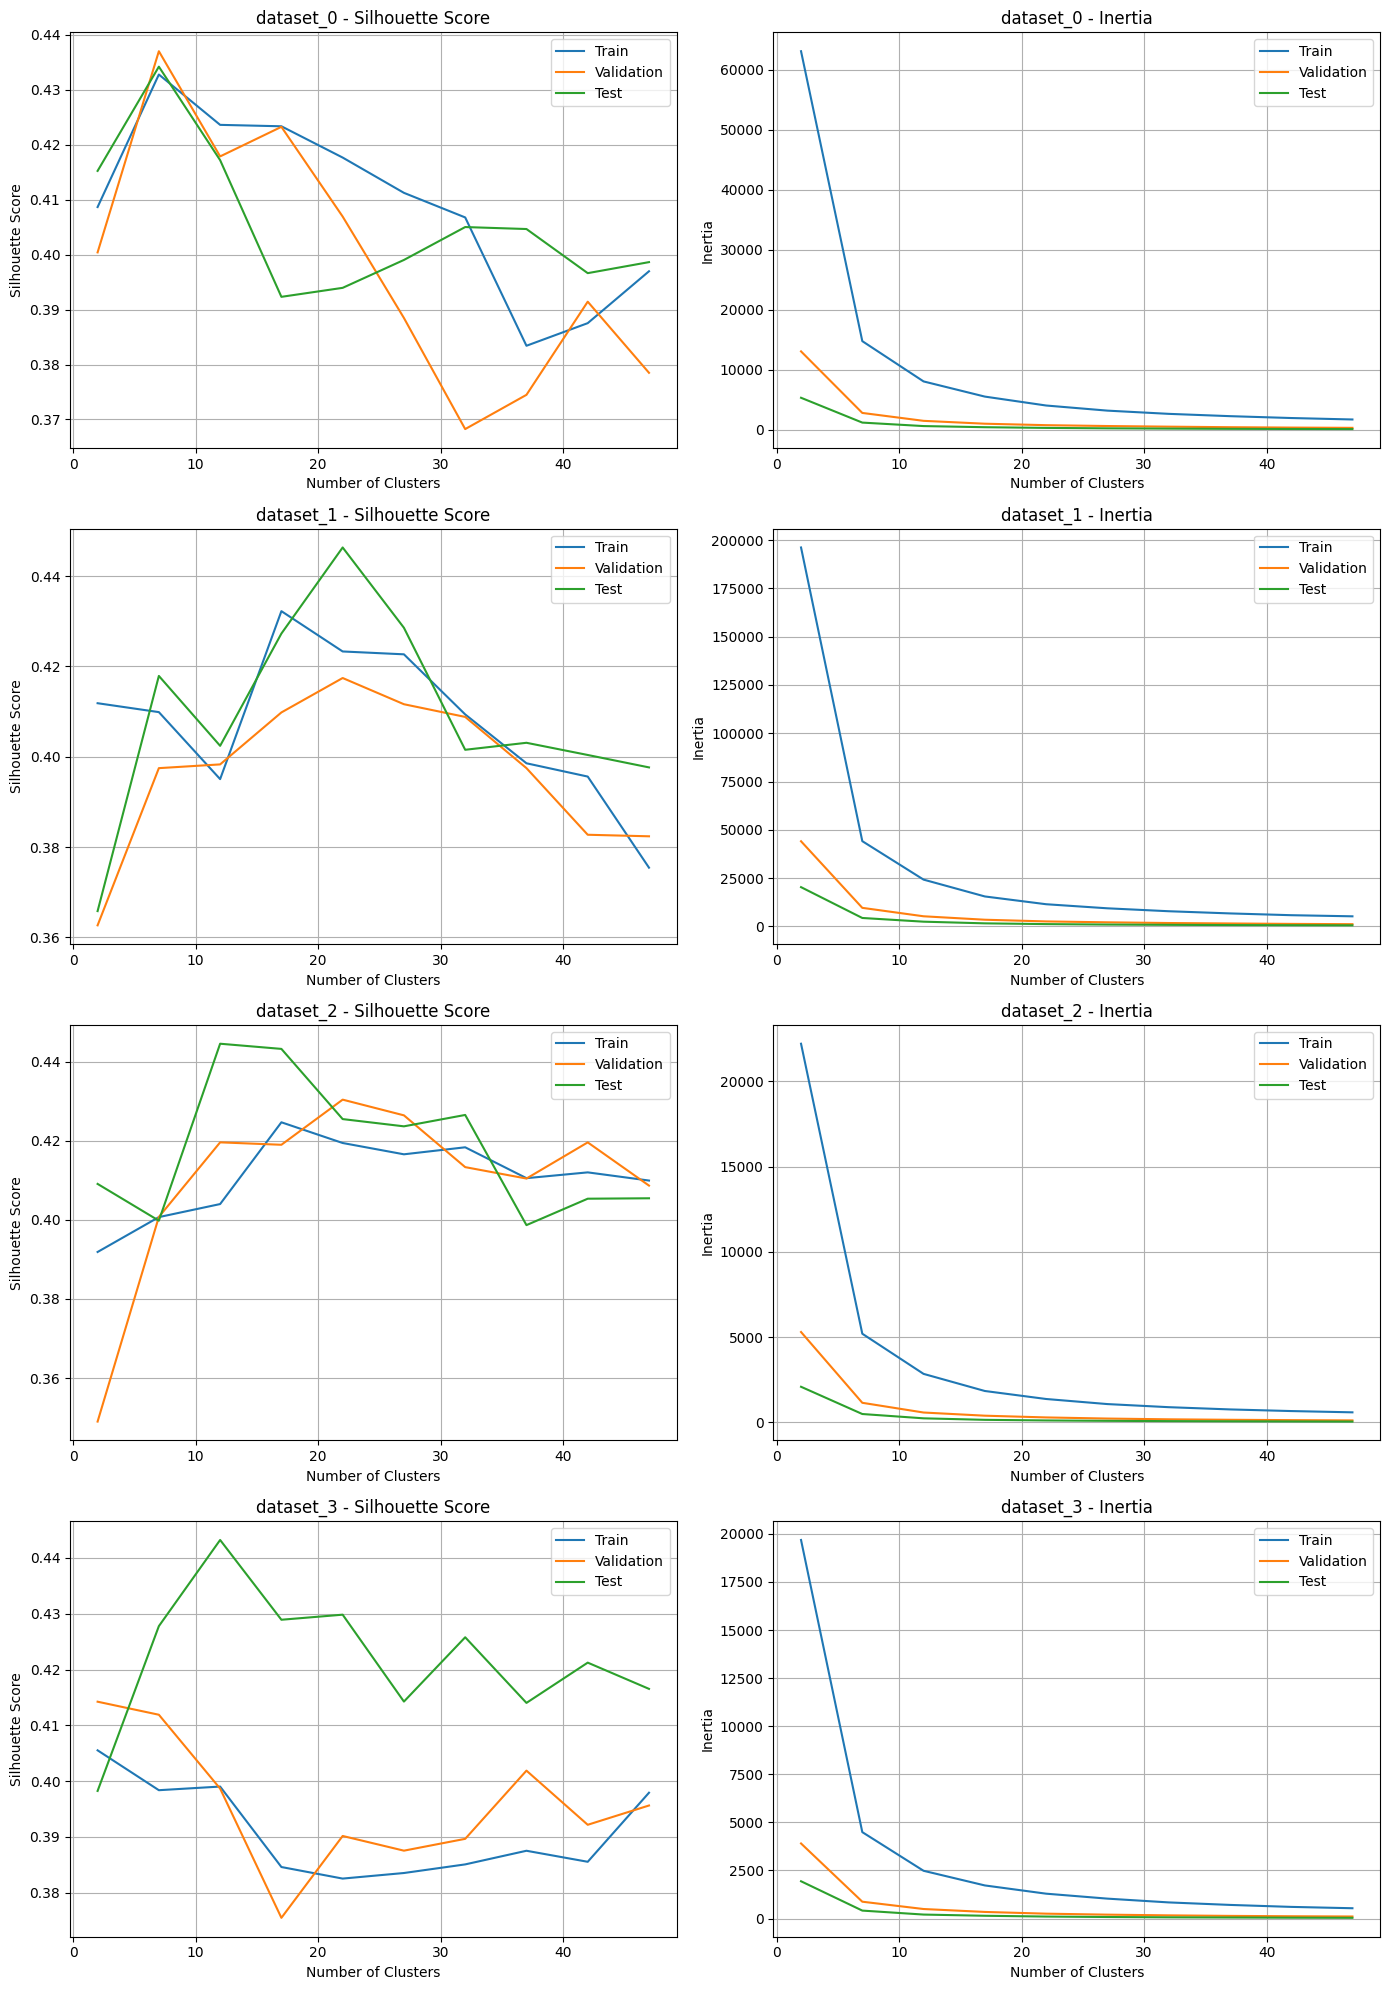

In [23]:
cluster_list = list(cluster_range)
num_datasets = len(all_results)
fig, axs = plt.subplots(num_datasets, 2, figsize=(14, 5 * num_datasets))

if num_datasets == 1:
    axs = axs.reshape(1, 2)

for i, (dataset_name, results) in enumerate(all_results.items()):
    for split_name in results:
        axs[i, 0].plot(cluster_list, results[split_name]['silhouette'], label=split_name)
    axs[i, 0].set_title(f'{dataset_name} - Silhouette Score')
    axs[i, 0].set_xlabel('Number of Clusters')
    axs[i, 0].set_ylabel('Silhouette Score')
    axs[i, 0].grid(True)
    axs[i, 0].legend()

    for split_name in results:
        axs[i, 1].plot(cluster_list, results[split_name]['inertia'], label=split_name)
    axs[i, 1].set_title(f'{dataset_name} - Inertia')
    axs[i, 1].set_xlabel('Number of Clusters')
    axs[i, 1].set_ylabel('Inertia')
    axs[i, 1].grid(True)
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


In [30]:
week_1 = ClusterPostProcessor(best_k=7, df=processed_dfs[0], output_dir='experiment/kmeans/week_1')
clusters = week_1.run()

Batches: 100%|██████████| 483/483 [00:35<00:00, 13.79it/s]
/home/awr1u24/anaconda3/envs/research/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


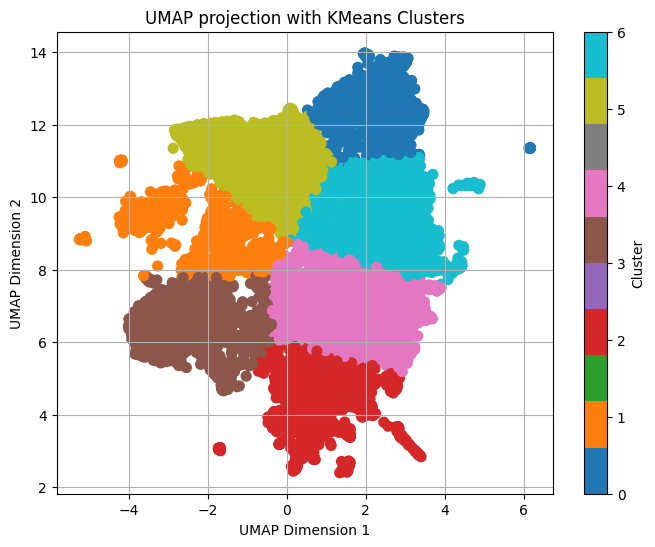

In [31]:
week_1.plot_clusters()

In [32]:
week_2 = ClusterPostProcessor(best_k=7, df=processed_dfs[1], output_dir='experiment/kmeans/week_2')
clusters = week_2.run()

Batches: 100%|██████████| 1253/1253 [01:25<00:00, 14.60it/s]
/home/awr1u24/anaconda3/envs/research/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


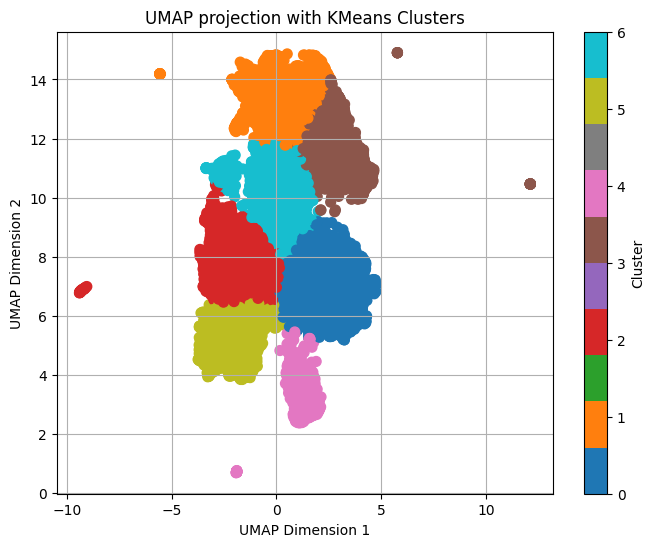

In [33]:
week_2.plot_clusters()

Batches: 100%|██████████| 207/207 [00:16<00:00, 12.82it/s]
/home/awr1u24/anaconda3/envs/research/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


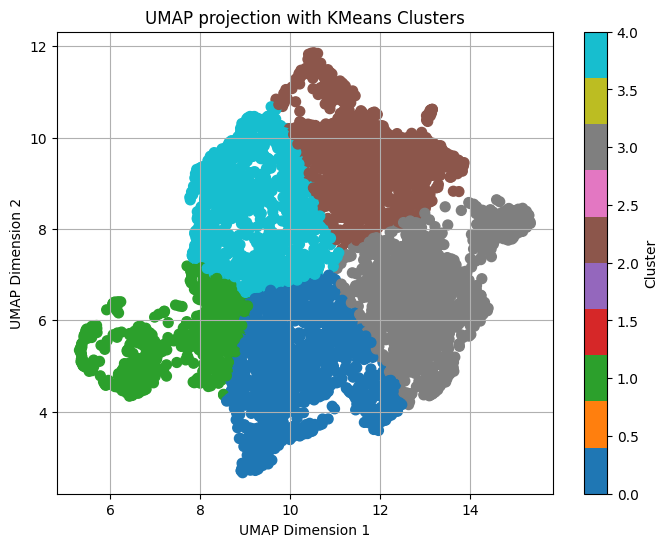

In [ ]:
week_3 = ClusterPostProcessor(best_k=5, df=processed_dfs[2], output_dir='experiment/kmeans/week_3')
clusters = week_3.run()
week_3.plot_clusters()

Batches: 100%|██████████| 184/184 [00:10<00:00, 17.12it/s]
/home/awr1u24/anaconda3/envs/research/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


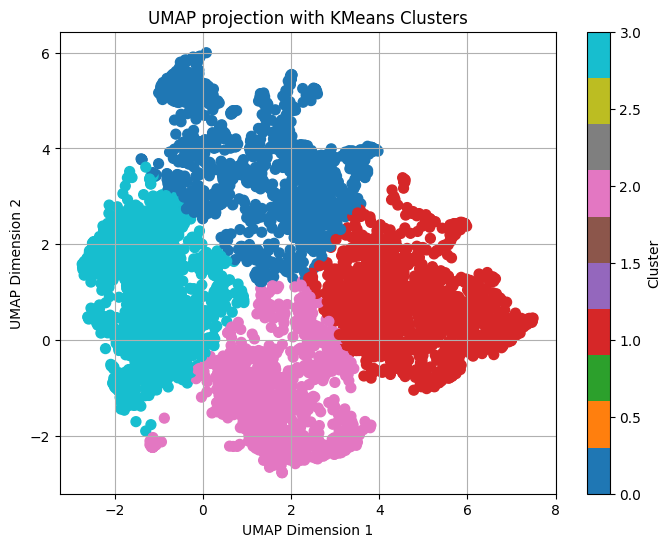

In [35]:
week_4 = ClusterPostProcessor(best_k=4, df=processed_dfs[3], output_dir='experiment/kmeans/week_4')
clusters = week_4.run()
week_4.plot_clusters()

In [7]:
text_column = 'text'
num_topics = 5
passes = 10
workers = 2
results = []
custom_stopwords = [
    'yg', 'di', 'dan', 'itu', 'ini', 'yang', 'ada', 'ke', 'dari', 'untuk',
    'saja', 'juga', 'atau', 'dengan', 'tdk', 'kok', 'si', 'kan', 'lagi', 'pada',
    'hanya', 'terus', 'mana', 'seperti', 'aja', 'gak', 'ya', 'ga', 'gk',
    'kalo', 'kalau', 'udah', 'biar', 'tau', 'jangan', 'org', 'anda', 'saya',
    'mereka', 'pak', 'ibu', 'dia', 'sdh', 'masih', 'karena', 'apa','nya'
]

for i, file_path in enumerate(glob('experiment/**/*.csv', recursive=True)):
    df = pd.read_csv(file_path)
    print(f"\nProcessing DataFrame #{i+1} from file: {file_path}")
    week_name = os.path.basename(os.path.dirname(file_path))
    cluster_name = os.path.splitext(os.path.basename(file_path))[0]
    
    lda = LDAProcessor(df, text_column=text_column, num_topics=num_topics, passes=passes, workers=workers, custom_stopwords=custom_stopwords)
    processed_texts = lda.prepare_corpus()
    lda.train_lda()
    topics = lda.lda_model.print_topics(num_words=5)
    topics_str = "\n".join([f"Topic #{idx}: {topic}" for idx, topic in topics])
    coherence = lda.compute_coherence(processed_texts)
    print(f"Coherence Score: {coherence:.4f}")
    
    results.append({
        'week': week_name,
        'cluster': cluster_name,
        'file': file_path,
        'coherence': coherence,
        'topics': topics_str
    })

results_df = pd.DataFrame(results)
print(results_df)


Processing DataFrame #1 from file: experiment/kmeans/week_3/cluster_0.csv
Coherence Score: 0.4115

Processing DataFrame #2 from file: experiment/kmeans/week_3/cluster_1.csv
Coherence Score: 0.4502

Processing DataFrame #3 from file: experiment/kmeans/week_3/cluster_4.csv
Coherence Score: 0.2370

Processing DataFrame #4 from file: experiment/kmeans/week_3/cluster_3.csv
Coherence Score: 0.3044

Processing DataFrame #5 from file: experiment/kmeans/week_3/cluster_2.csv
Coherence Score: 0.3532

Processing DataFrame #6 from file: experiment/kmeans/week_4/cluster_0.csv
Coherence Score: 0.3047

Processing DataFrame #7 from file: experiment/kmeans/week_4/cluster_1.csv
Coherence Score: 0.4466

Processing DataFrame #8 from file: experiment/kmeans/week_4/cluster_3.csv
Coherence Score: 0.2980

Processing DataFrame #9 from file: experiment/kmeans/week_4/cluster_2.csv
Coherence Score: 0.2779

Processing DataFrame #10 from file: experiment/kmeans/week_1/cluster_0.csv
Coherence Score: 0.3012

Processi

In [ ]:
num_topics = 5
passes = 10
workers = 2

additional_week = []

for i in range(4,6):
    df = list_dfs_weekly[i]
    lda = LDAProcessor(df, text_column=text_column, num_topics=num_topics, passes=passes, workers=workers, custom_stopwords=custom_stopwords)
    processed_texts = lda.prepare_corpus()
    week_name = f'week_{i}'
    lda.train_lda()
    topics = lda.lda_model.print_topics(num_words=5)
    topics_str = "\n".join([f"Topic #{idx}: {topic}" for idx, topic in topics])
    coherence = lda.compute_coherence(processed_texts)
    print(f"Coherence Score: {coherence:.4f}")
    additional_week.append({
        'week': week_name,
        'coherence': coherence,
        'topics': topics_str
    })

additional_week_df = pd.DataFrame(additional_week)
print(additional_week_df)

In [ ]:
combine_topic = pd.concat([results_df, additional_week_df], axis=0, ignore_index=True, sort=False)
combine_topic.to_csv('experiment/lda_results_combined.csv', index=False)